<a href="https://colab.research.google.com/github/shengjinbiao/DeepSeek-OCR/blob/main/DeepSeek_OCR_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepSeek-OCR on Google Colab

This notebook sets up and runs the DeepSeek-OCR model for optical character recognition.

**Requirements:**
- GPU Runtime (T4 or better recommended)
- ~15-20 minutes setup time

**Based on:** https://github.com/deepseek-ai/DeepSeek-OCR

In [3]:
#加载谷歌硬盘，用于永久保存文件
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Environment Setup and GPU Check

In [4]:
# Check GPU availability
!nvidia-smi

import torch
print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

Mon Oct 27 12:41:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 2. Clone Repository

In [14]:
# Clone the DeepSeek-OCR repository
!git clone https://github.com/deepseek-ai/DeepSeek-OCR.git /content/DeepSeek-OCR
%cd /content/DeepSeek-OCR

fatal: destination path '/content/DeepSeek-OCR' already exists and is not an empty directory.
/content/DeepSeek-OCR


## 3. Install Dependencies

Installing PyTorch, transformers, and other required packages.

In [6]:
# Install PyTorch with CUDA support (Colab typically has CUDA 11.8 or 12.1)
# Note: Colab may already have PyTorch installed, but we ensure compatible version
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [15]:
# Install requirements from the repository
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 123.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 114.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 10.7 MB/s eta 0:00:00
  Created wheel for img2pdf: filename=img2pdf-0.6.1-py3-none-any.whl size=51001 sha256=94cc2d8608dce7c1dd0f6c93dcaf07df965f75f1314d3f681cc5838f5ef1f4e1
  Stored in directory: /root/.cache/pip/wheels/a5/05/56/c05447973db749cd2178b8f95e36f007f0af5f5dce2c6197a5
Successfully built img2pdf
  Attempting uninstall: wrapt
    Found existing installation: wrapt 2.0.0
    Uninstalling wrapt-2.0.0:
      Successf

In [2]:
try:
    import addict
    print("Addict library is installed.")
except ImportError:
    print("Addict library not found. Installing...")
    !pip install addict
    import addict
    print("Addict library installed successfully.")

Addict library is installed.


In [1]:
# Install flash-attention (this may take 5-10 minutes to compile)
!pip install flash-attn==2.7.3 --no-build-isolation

## 4. Upload Test Image

Upload your Capture.PNG file here.

Please upload your Capture.PNG file:


Saving page_25.png to page_25.png

Uploaded file: page_25.png

Preview of uploaded image:


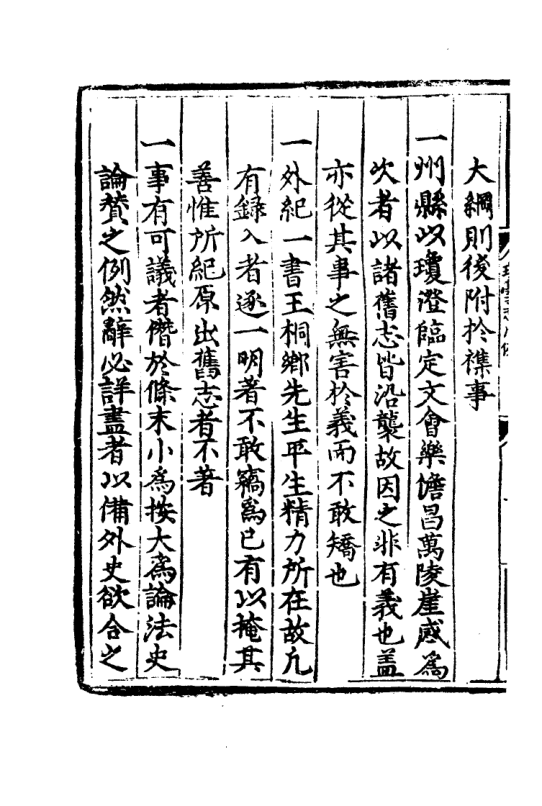

In [18]:
from google.colab import files
from IPython.display import Image, display
import os

# Upload the image
print("Please upload your Capture.PNG file:")
uploaded = files.upload()

# Get the uploaded filename
image_path = list(uploaded.keys())[0]
print(f"\nUploaded file: {image_path}")

# Display the uploaded image
print("\nPreview of uploaded image:")
display(Image(filename=image_path))

In [19]:
import os
print(f"Current working directory: {os.getcwd()}")

Current working directory: /content/drive/MyDrive/DeepSeekOCR


In [12]:
# Reinstall flash-attention with specific CUDA version
# Check your CUDA version with !nvidia-smi and adjust cu121 if necessary
!pip install flash-attn==2.7.3 --no-build-isolation --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


## 5. Load DeepSeek-OCR Model

This will download the model from HuggingFace (may take a few minutes).

In [4]:
from transformers import AutoModel, AutoTokenizer
import torch
import os

print("Loading DeepSeek-OCR model...")
print("This may take several minutes on first run...\n")

# Ensure the correct working directory
%cd /content/drive/MyDrive/DeepSeekOCR

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
model_name = 'deepseek-ai/DeepSeek-OCR'

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# Removing attn_implementation='flash_attention_2' as a troubleshooting step
model = AutoModel.from_pretrained(model_name, trust_remote_code=True, use_safetensors=True)
model = model.eval().cuda().to(torch.bfloat16)

print("Model loaded successfully!")
print(f"Model device: {next(model.parameters()).device}")
print(f"Model dtype: {next(model.parameters()).dtype}")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Loading DeepSeek-OCR model...
This may take several minutes on first run...

/content/drive/MyDrive/DeepSeekOCR


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


deepencoder.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/deepseek-ai/DeepSeek-OCR:
- deepencoder.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


conversation.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/deepseek-ai/DeepSeek-OCR:
- conversation.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_deepseekv2.py: 0.00B [00:00, ?B/s]

configuration_deepseek_v2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/deepseek-ai/DeepSeek-OCR:
- configuration_deepseek_v2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/deepseek-ai/DeepSeek-OCR:
- modeling_deepseekv2.py
- configuration_deepseek_v2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/deepseek-ai/DeepSeek-OCR:
- deepencoder.py
- conversation.py
- modeling_deepseekv2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekO

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-000001.safetensors:   0%|          | 0.00/6.67G [00:00<?, ?B/s]

Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at deepseek-ai/DeepSeek-OCR and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!
Model device: cuda:0
Model dtype: torch.bfloat16


In [5]:
from transformers import AutoModel, AutoTokenizer
import torch
import os

print("Loading DeepSeek-OCR model...")
print("This may take several minutes on first run...\n")

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
model_name = 'deepseek-ai/DeepSeek-OCR'

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# Removing attn_implementation='flash_attention_2' as a troubleshooting step
model = AutoModel.from_pretrained(model_name, trust_remote_code=True, use_safetensors=True)
model = model.eval().cuda().to(torch.bfloat16)

print("Model loaded successfully!")
print(f"Model device: {next(model.parameters()).device}")
print(f"Model dtype: {next(model.parameters()).dtype}")

Loading DeepSeek-OCR model...
This may take several minutes on first run...



You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at deepseek-ai/DeepSeek-OCR and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!
Model device: cuda:0
Model dtype: torch.bfloat16


## 6. Run OCR Inference

In [21]:
from PIL import Image
import time
import os
import torch
from google.colab import files
from IPython.display import Image, display

print("Running OCR inference using model.infer...\n")
start_time = time.time()

# Upload the image if image_path is not defined
try:
    # Check if image_path is already defined (e.g., from a previous upload cell)
    image_path
except NameError:
    print("Please upload your image for OCR:")
    uploaded = files.upload()
    # Get the uploaded filename
    image_path = list(uploaded.keys())[0]
    print(f"\nUploaded file: {image_path}")

    # Display the uploaded image
    print("\nPreview of uploaded image:")
    display(Image(filename=image_path))


# Define prompt and output path
# prompt = "<image>\nFree OCR. "
prompt = "<image>\n<|grounding|>Convert the document to markdown. "
output_path = '/content/drive/MyDrive/DeepSeekOCR/ocr_output' # Define an output directory

# Create output directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Run inference using the infer method
with torch.no_grad():
    # infer(self, tokenizer, prompt='', image_file='', output_path = ' ', base_size = 1024, image_size = 640, crop_mode = True, test_compress = False, save_results = False):

    # Tiny: base_size = 512, image_size = 512, crop_mode = False
    # Small: base_size = 640, image_size = 640, crop_mode = False
    # Base: base_size = 1024, image_size = 1024, crop_mode = False
    # Large: base_size = 1280, image_size = 1280, crop_mode = False

    # Gundam: base_size = 1024, image_size = 640, crop_mode = True

    res = model.infer(tokenizer,
                      prompt=prompt,
                      image_file=image_path, # Use the uploaded image path
                      output_path=output_path,
                      base_size=1024,
                      image_size=640,
                      crop_mode=True,
                      save_results=True,
                      test_compress=True)

end_time = time.time()

print(f"Inference completed in {end_time - start_time:.2f} seconds\n")
print("=" * 80)
print("OCR RESULT:")
print("=" * 80)
# The infer method might return different formats,
# we will assume it returns the text directly or in a structure we can access.
# You might need to adjust this based on the actual output format of model.infer
print(res)
print("=" * 80)

# Note: The infer method with save_results=True should save the output to output_path
# You might need to adjust the saving and downloading logic in the next cell
# depending on how model.infer saves the results.

# After running this cell and the cell to read the output file, you can use the
# display_image_and_text function from cell 1c499536 to compare the image and text.
# Example: display_image_and_text(image_path, ocr_text_from_file)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Running OCR inference using model.infer...

BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
<|ref|>sub_title<|/ref|><|det|>[[833, 190, 900, 511]]<|/det|>
大綱則後附於祿事 

<|ref|>text<|/ref|><|det|>[[590, 170, 833, 848]]<|/det|>
一州縣以瓊澄臨定文會樂儔昌萬陵崖威爲
次者以諸舊志皆沿襲故因之非有義也蓋
亦從其事之無害於義而不敢矯也 

<|ref|>text<|/ref|><|det|>[[499, 170, 600, 848]]<|/det|>
一外紀一書玉相鄒先生平生精力所在故凡
有錄入者遂一明著不敢竊爲已有以掩其 

<|ref|>text<|/ref|><|det|>[[303, 190, 504, 848]]<|/det|>
善惟所紀原出舊志者不著
一事有可議者僧於條末小爲按大爲論法史
一 

<|ref|>text<|/ref|><|det|>[[167, 199, 320, 848]]<|/det|>
論贊之例然辭必詳盡者以備外史欲合之
image size:  (542, 806)
valid image tokens:  772
output texts tokens (valid):  237
compression ratio:  0.31
===============save results:===============


image: 0it [00:00, ?it/s]
other: 100%|██████████| 5/5 [00:00<00:00, 56987.83it/s]

Inference completed in 11.58 seconds

OCR RESULT:
None


In [10]:
import os

output_path = '/content/drive/MyDrive/DeepSeekOCR/ocr_output'

print(f"Checking the output directory: {output_path}")

if os.path.exists(output_path):
    files_in_output = os.listdir(output_path)
    print(f"Files found in {output_path}: {files_in_output}")

    # Assuming the output file has a .txt or .md extension and is the only one there
    # You might need to adjust this if the output format is different or there are multiple files
    ocr_output_file = None
    for file_name in files_in_output:
        if file_name.endswith('.mmd'): # Changed to check for .mmd extension
            ocr_output_file = os.path.join(output_path, file_name)
            break

    if ocr_output_file and os.path.exists(ocr_output_file):
        print(f"\nReading content from: {ocr_output_file}\n")
        with open(ocr_output_file, 'r', encoding='utf-8') as f:
            ocr_text = f.read()
            print("=" * 80)
            print("SAVED OCR RESULT:")
            print("=" * 80)
            print(ocr_text)
            print("=" * 80)
    else:
        print("\nNo .mmd output file found in the directory.") # Updated message
else:
    print("\nOutput directory does not exist.")

Checking the output directory: /content/drive/MyDrive/DeepSeekOCR/ocr_output
Files found in /content/drive/MyDrive/DeepSeekOCR/ocr_output: ['images', 'result.mmd', 'result_with_boxes.jpg']

Reading content from: /content/drive/MyDrive/DeepSeekOCR/ocr_output/result.mmd

SAVED OCR RESULT:

外紀一書亦得側於諸家遺集以補郡志
之缺略自郡縣建置治革至於山川形勝
軍衛城池學校人物户口貢賦等事與凡
事有關涉風化利益軍民者一一脩舉俱
要事無遺漏人無遺憾爲一代全書以副
郡守朝夕憂勤報國之心經始於正德六
年某月日告成於某月日一一皆資公定
其可否而江右貳守李公贊成其事余議
以佐年歲優多首辱延訪俾爲之序其首


## 8. Batch Processing (Optional)

Process multiple images at once.

In [13]:
from PIL import Image
import time
import os
import torch
from google.colab import files
from IPython.display import Image, display

# Upload multiple images
print("Upload multiple images for batch processing:")
uploaded_files = files.upload()

results = {}
output_path = '/content/drive/MyDrive/DeepSeekOCR/batch_ocr_output' # Define a directory for batch output

# Create output directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

for filename in uploaded_files.keys():
    print(f"\nProcessing {filename}...")

    try:
        # Construct the full image path in the current working directory
        image_path = os.path.join(os.getcwd(), filename)

        # Define prompt (adjust based on DeepSeek-OCR's expected format)
        prompt = "<image>\n<|grounding|>Convert the document to markdown. "

        with torch.no_grad():
            # Use the infer method for batch processing
            res = model.infer(tokenizer,
                              prompt=prompt,
                              image_file=image_path, # Use the uploaded image path
                              output_path=output_path,
                              base_size=1024,
                              image_size=640,
                              crop_mode=True,
                              save_results=True,
                              test_compress=True)

            # The infer method with save_results=True saves the output to output_path
            # You might need to adjust how to retrieve or confirm the saved result
            # For this example, we'll just note that it was processed.
            results[filename] = f"Processed. Output saved to {output_path}"
            print(f"✓ {filename} processed successfully. Output saved to {output_path}")

    except Exception as e:
        print(f"✗ Error processing {filename}: {str(e)}")
        results[filename] = f"Error: {str(e)}"

# Display all results (or confirmation of processing)
print("\n" + "=" * 80)
print("BATCH PROCESSING SUMMARY")
print("=" * 80)

for filename, result in results.items():
    print(f"\n--- {filename} ---")
    print(result)
    print()

print(f"\nDetailed results are saved in the directory: {output_path}")

# Note: Downloading the batch results as a single file might require
# zipping the output directory or iterating through saved files.
# This part is commented out as model.infer handles saving.
# with open('batch_results.txt', 'w', encoding='utf-8') as f:
#     for filename, result in results.items():
#         f.write(f"{'='*80}\n")
#         f.write(f"File: {filename}\n")
#         f.write(f"{'='*80}\n")
#         f.write(result)
#         f.write(f"\n\n")
#
# files.download('batch_results.txt')

Upload multiple images for batch processing:


/usr/local/lib/python3.12/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Saving page_150.png to page_150.png

Processing page_150.png...
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
<|ref|>text<|/ref|><|det|>[[690, 149, 833, 848]]<|/det|>
恩縣屬崖州
用知州
詳
請
正
統
五
年
皆
三
州
附
郭
宜 

<|ref|>text<|/ref|><|det|>[[596, 111, 700, 848]]<|/det|>
僞萬寧寧遠三縣
程
用
知
府
請
今
領
州
三
縣
十 

<|ref|>text<|/ref|><|det|>[[500, 149, 608, 848]]<|/det|>
環山縣附郭本漢朱崖縣璘賜地隋於其東境
置顏盧縣 

<|ref|>text<|/ref|><|det|>[[460, 149, 515, 248]]<|/det|>
資五年 

<|ref|>text<|/ref|><|det|>[[460, 245, 515, 348]]<|/det|>
復置縣 

<|ref|>text<|/ref|><|det|>[[460, 345, 515, 848]]<|/det|>
唐武德初於顏盧置崖州 

<|ref|>text<|/ref|><|det|>[[367, 149, 470, 848]]<|/det|>
開宋
州
熙
寧
四
年
省
唐
武
德
初
於
顏
盧
置
崖
州
開
宋 

<|ref|>text<|/ref|><|det|>[[275, 149, 374, 848]]<|/det|>
年廢
貞觀五年
始於崖州之環山地置環州倚 

<|ref|>text<|/ref|><|det|>[[184, 149, 285, 848]]<|/det|>
郭置環山縣十三年析置曾口今
南境
顏羅容 

<|ref|>text<|/ref|><|det|>[[94, 149, 196, 848]]<|/det|>
環今樂三縣俱乾封後設山崗蠻貞元間李復討復元至元間 

<|ref|>text<|/ref|><|det|>[[50, 149, 106, 848]]<|/det|>
乾封後陷山崗蠻

image: 0it [00:00, ?it/s]
other: 100%|██████████| 11/11 [00:00<00:00, 146467.76it/s]

✓ page_150.png processed successfully. Output saved to /content/drive/MyDrive/DeepSeekOCR/batch_ocr_output

BATCH PROCESSING SUMMARY

--- page_150.png ---
Processed. Output saved to /content/drive/MyDrive/DeepSeekOCR/batch_ocr_output


Detailed results are saved in the directory: /content/drive/MyDrive/DeepSeekOCR/batch_ocr_output


Displaying Single Image and OCR Result:



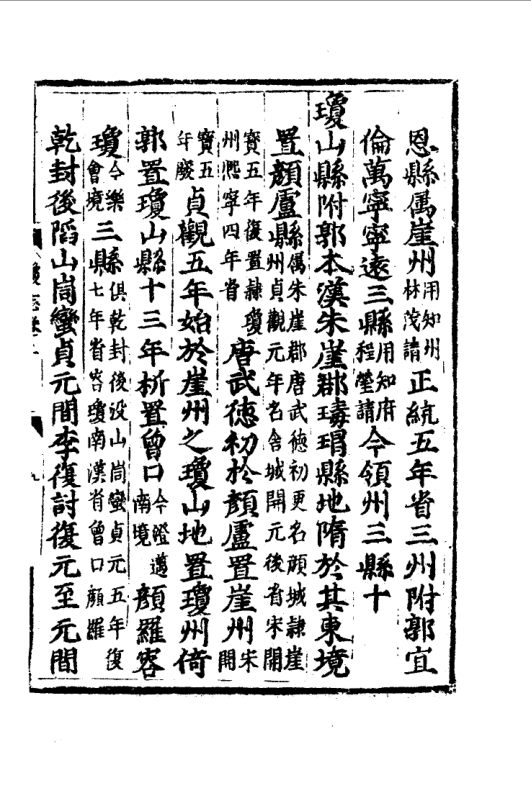


Displaying Last Batch Processed Image and OCR Result:



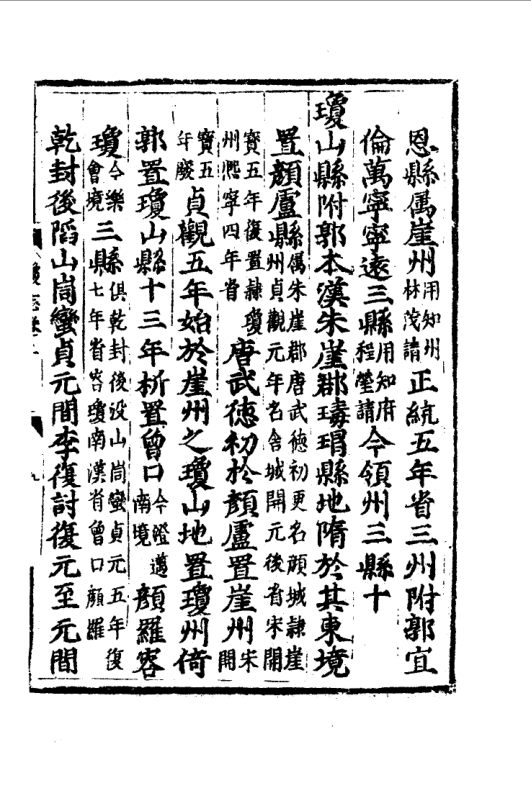

In [15]:
from IPython.display import display, HTML, Image

def display_image_and_text(image_path, ocr_text):
    """
    Displays an image and its corresponding OCR text side-by-side in two panels.
    """
    # Read the image and encode it in base64 for embedding in HTML
    # This avoids issues with file paths in the HTML display
    try:
        from base64 import b64encode
        with open(image_path, 'rb') as f:
            image_bytes = f.read()
        image_base64 = b64encode(image_bytes).decode('utf-8')
        image_tag = f'<img src="data:image/png;base64,{image_base64}" style="max-width: 100%; height: auto;">'
    except Exception as e:
        image_tag = f"Could not load image: {e}"
        print(f"Error loading image {image_path}: {e}")


    # Create the HTML structure for two panels
    html_content = f"""
    <div style="display: flex; gap: 20px;">
        <div style="flex: 1;">
            <h3>Original Image</h3>
            {image_tag}
        </div>
        <div style="flex: 1; overflow-y: auto; max-height: 600px; border: 1px solid #ccc; padding: 10px;">
            <h3>OCR Text</h3>
            <pre style="white-space: pre-wrap; word-wrap: break-word;">{ocr_text}</pre>
        </div>
    </div>
    """
    display(HTML(html_content))

# --- Example Usage ---
# You would replace 'path/to/your/image.png' and 'Your OCR text here'
# with the actual path to your image and the text result from the OCR.

# Example with the single image run
single_image_path = image_path # Use the path from the single image upload
single_ocr_output_file = '/content/drive/MyDrive/DeepSeekOCR/ocr_output/result.mmd' # Path to the saved single OCR result

single_ocr_text = "Could not read OCR text file."
if os.path.exists(single_ocr_output_file):
    try:
        with open(single_ocr_output_file, 'r', encoding='utf-8') as f:
            single_ocr_text = f.read()
    except Exception as e:
        single_ocr_text = f"Error reading OCR text file: {e}"
        print(f"Error reading {single_ocr_output_file}: {e}")

print("Displaying Single Image and OCR Result:")
display_image_and_text(single_image_path, single_ocr_text)

# Example with one of the batch processed images (assuming page_150.png was processed)
# You would need to know the specific image name uploaded during batch processing
# and the corresponding output file name if it's different from result.mmd
# For this example, we'll assume the last uploaded batch image and the same output file name structure.
batch_image_filename = list(uploaded_files.keys())[0] if 'uploaded_files' in locals() and uploaded_files else None
batch_image_path = os.path.join(os.getcwd(), batch_image_filename) if batch_image_filename else None
batch_ocr_output_file = '/content/drive/MyDrive/DeepSeekOCR/batch_ocr_output/result.mmd' # Path to the saved batch OCR result

batch_ocr_text = "Could not read batch OCR text file."
if batch_image_path and os.path.exists(batch_ocr_output_file):
     try:
        with open(batch_ocr_output_file, 'r', encoding='utf-8') as f:
            batch_ocr_text = f.read()
     except Exception as e:
        batch_ocr_text = f"Error reading batch OCR text file: {e}"
        print(f"Error reading {batch_ocr_output_file}: {e}")


if batch_image_path:
    print("\nDisplaying Last Batch Processed Image and OCR Result:")
    display_image_and_text(batch_image_path, batch_ocr_text)
else:
    print("\nNo batch processed image found to display.")

In [14]:
import os

batch_output_path = '/content/drive/MyDrive/DeepSeekOCR/batch_ocr_output'

print(f"Checking the batch output directory: {batch_output_path}")

if os.path.exists(batch_output_path):
    files_in_batch_output = os.listdir(batch_output_path)
    print(f"Files found in {batch_output_path}: {files_in_batch_output}")

    # Assuming the output files have .mmd extension
    for file_name in files_in_batch_output:
        if file_name.endswith('.mmd'):
            batch_ocr_output_file = os.path.join(batch_output_path, file_name)
            print(f"\nReading content from: {batch_ocr_output_file}\n")
            with open(batch_ocr_output_file, 'r', encoding='utf-8') as f:
                ocr_text = f.read()
                print("=" * 80)
                print(f"BATCH OCR RESULT ({file_name}):")
                print("=" * 80)
                print(ocr_text)
                print("=" * 80)
else:
    print("\nBatch output directory does not exist.")

Checking the batch output directory: /content/drive/MyDrive/DeepSeekOCR/batch_ocr_output
Files found in /content/drive/MyDrive/DeepSeekOCR/batch_ocr_output: ['images', 'result.mmd', 'result_with_boxes.jpg']

Reading content from: /content/drive/MyDrive/DeepSeekOCR/batch_ocr_output/result.mmd

BATCH OCR RESULT (result.mmd):

恩縣屬崖州
用知州
詳
請
正
統
五
年
皆
三
州
附
郭
宜 


僞萬寧寧遠三縣
程
用
知
府
請
今
領
州
三
縣
十 


環山縣附郭本漢朱崖縣璘賜地隋於其東境
置顏盧縣 


資五年 


復置縣 


唐武德初於顏盧置崖州 


開宋
州
熙
寧
四
年
省
唐
武
德
初
於
顏
盧
置
崖
州
開
宋 


年廢
貞觀五年
始於崖州之環山地置環州倚 


郭置環山縣十三年析置曾口今
南境
顏羅容 


環今樂三縣俱乾封後設山崗蠻貞元間李復討復元至元間 


乾封後陷山崗蠻貞元間李復討復元至元


In [ ]:
from PIL import Image
import time
import os
import torch

# Upload multiple images
print("Upload multiple images for batch processing:")
uploaded_files = files.upload()

results = {}
output_path = '/content/drive/MyDrive/DeepSeekOCR/batch_ocr_output2' # Define a directory for batch output

# Create output directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

for filename in uploaded_files.keys():
    print(f"\nProcessing {filename}...")

    try:
        # Construct the full image path in the current working directory
        image_path = os.path.join(os.getcwd(), filename)

        # Define prompt (adjust based on DeepSeek-OCR's expected format)
        prompt = "<image>\n<|grounding|>Convert the document to markdown. "

        with torch.no_grad():
            # Use the infer method for batch processing
            res = model.infer(tokenizer,
                              prompt=prompt,
                              image_file=image_path, # Use the uploaded image path
                              output_path=output_path,
                              base_size=1024,
                              image_size=640,
                              crop_mode=True,
                              save_results=True,
                              test_compress=True)

            # The infer method with save_results=True saves the output to output_path
            # You might need to adjust how to retrieve or confirm the saved result
            # For this example, we'll just note that it was processed.
            results[filename] = f"Processed. Output saved to {output_path}"
            print(f"✓ {filename} processed successfully. Output saved to {output_path}")

    except Exception as e:
        print(f"✗ Error processing {filename}: {str(e)}")
        results[filename] = f"Error: {str(e)}"

# Display all results (or confirmation of processing)
print("\n" + "=" * 80)
print("BATCH PROCESSING SUMMARY")
print("=" * 80)

for filename, result in results.items():
    print(f"\n--- {filename} ---")
    print(result)
    print()

print(f"\nDetailed results are saved in the directory: {output_path}")

# Note: Downloading the batch results as a single file might require
# zipping the output directory or iterating through saved files.
# This part is commented out as model.infer handles saving.
# with open('batch_results.txt', 'w', encoding='utf-8') as f:
#     for filename, result in results.items():
#         f.write(f"{'='*80}\n")
#         f.write(f"File: {filename}\n")
#         f.write(f"{'='*80}\n")
#         f.write(result)
#         f.write(f"\n\n")
#
# files.download('batch_results.txt')

In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch
import os

print("Loading DeepSeek-OCR model for batch processing...")

# Ensure the correct working directory
%cd /content/drive/MyDrive/DeepSeekOCR

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
model_name = 'deepseek-ai/DeepSeek-OCR'

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# Removing attn_implementation='flash_attention_2' as a troubleshooting step
model = AutoModel.from_pretrained(model_name, trust_remote_code=True, use_safetensors=True)
model = model.eval().cuda().to(torch.bfloat16)

print("Model loaded successfully for batch processing!")

## Troubleshooting

### Common Issues:

1. **Out of Memory (OOM):**
   - Use a higher-tier GPU (A100, V100)
   - Reduce image resolution before processing
   - Enable gradient checkpointing

2. **Flash Attention Installation Fails:**
   - Try removing `attn_implementation='flash_attention_2'` parameter
   - Fallback to standard attention mechanism

3. **Model Download Slow:**
   - This is normal for large models (may take 10-15 minutes)
   - Model is cached after first download

4. **Image Format Issues:**
   - Ensure image is in RGB format
   - Convert: `img = img.convert('RGB')`

### Performance Tips:

- Use images close to native resolutions: 512×512, 640×640, 1024×1024, 1280×1280
- For faster inference, use `torch.float16` (already enabled)
- Batch processing is more efficient for multiple images

## Cleanup (Optional)

Free up GPU memory when done.

In [ ]:
# Clear GPU memory
import gc

del model
del tokenizer
gc.collect()
torch.cuda.empty_cache()

print("GPU memory cleared")